
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EffiSciencesResearch/hackathon42/blob/main/starting_pack_hackathon42.ipynb)


In [ ]:
# This can take a moment
# Please install git large file system before cloning
!git lfs install
!git clone https://github.com/EffiSciencesResearch/hackathon42.git

# If the repo is private
# !git clone https://yourToken@github.com/EffiSciencesResearch/hackathon42.git

In [ ]:
%cd /content/hackathon42

import numpy as np
from tqdm.notebook import tqdm
import os
from os.path import join
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

datasets_names = sorted(os.listdir(path='datasets'), key=lambda name: int(name[:2]))
datasets_names = {int(datasets_name.split("_")[0]): datasets_name for datasets_name in datasets_names}
print(datasets_names)

# You can choose the dataset here by modifying the brackets
dataset_name = join('datasets', datasets_names[1])
assert "01_mnist_cc" not in dataset_name, "This colab is destined for MNIST, and not for the other datasets. The code needs to be adapted :) "
print(dataset_name)

X_labeled = np.load(join(dataset_name, "X_labeled.npy"))
y_labeled = np.load(join(dataset_name, "y_labeled.npy"))
X_unlabeled = np.load(join(dataset_name, "X_unlabeled.npy"))
X_val = np.load(join(dataset_name, "X_val.npy"))


X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled)


X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device)
y_test = torch.tensor(y_test, device=device)

In [20]:
class LeNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()       
        
        # Could also be done with nn.sequential
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*4*11, 100)
        self.fc2 = nn.Linear(100, n_classes)
        self.flat = nn.Flatten()
        
    def forward(self, x):
        
        # Max pooling over a (2, 2) window
        out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = self.flat(out)
        out = F.relu(self.fc1(out))
        x = F.dropout(x, training=self.training)
        pred = self.fc2(out)
        
        return pred

net = LeNet().float()

In [21]:
import pandas as pd

tbatch = 100
nb_epochs = 20

nbbatchs = int(X_train.shape[0]/tbatch)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

net.train()

def evaluate(X_test):
    net.eval()
    with torch.no_grad():
        y_pred = net(X_test)
    correct_test = (torch.argmax(y_pred, axis=1) == y_test).sum().item()
    net.train()
    return correct_test/len(X_test)

for epoch in tqdm(range(nb_epochs)):  # loop over the dataset multiple times
    correct = 0
    for i in (range(nbbatchs)):
        
        optimizer.zero_grad()
        
        X_batch = X_train[i*tbatch:(i+1)*tbatch]
        y_batch = y_train[i*tbatch:(i+1)*tbatch]

        # Compute forward / backward
        y_pred = net(X_batch)
        correct += (torch.argmax(y_pred, axis=1) == y_batch).sum().item()

        loss = criterion(y_pred, y_batch)
        

        loss.backward()
        optimizer.step()
        # break
    print("acc train:", correct/X_train.shape[0], "acc test:", evaluate(X_test))




  0%|          | 0/20 [00:00<?, ?it/s]

acc train: 0.6778947368421052 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0


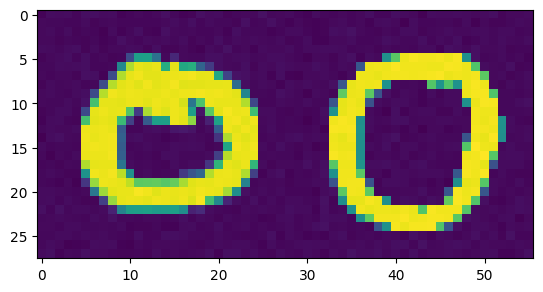

0



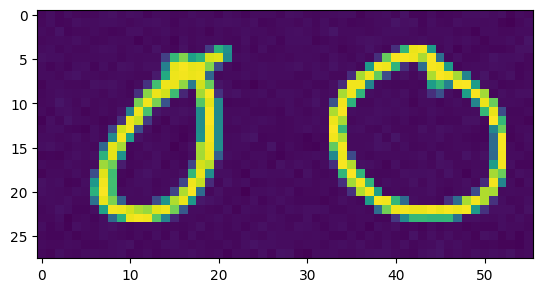

0



In [22]:
import matplotlib.pyplot as plt

for i in range(2):
    plt.imshow(X_labeled[i, 0])
    plt.show()
    print(y_labeled[i])
    print("")

In [23]:
net.train()
with torch.no_grad():
    y_pred = net(X_test)


print(y_pred.shape)
pred = torch.argmax(y_pred, dim=1)

pred = pred.numpy()
df = pd.DataFrame(pred)
df.to_csv("example_submission.csv", header=False, index=False)

torch.Size([317, 10])
